# Use Regression Analysis to Explore Data Replationships & Bad Data

## Quantifying relationships between variables

### What is a one-to-one line?

A one-to-one line is a line that represents what the relationship between 2 variables would be if their values were equal. For example, if Lidar and ground measurements of tree height were always equal, then observations of height would fall on the one-to-one line in a scatterplot.

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from math import *
import numpy as np
import pandas as pd
import rasterio as rio
import geopandas as gpd
import rasterstats as rs
import earthpy as et

# Setting consistent plotting style throughout notebook
sns.set_style("white")
sns.set(font_scale=1.5)

# Download data and set work dir
data = et.data.get_data("spatial-vector-lidar")
os.chdir(os.path.join(et.io.HOME, "earth-analytics"))

lidar_path = os.path.join("data", "spatial-vector-lidar",
                         "california", "neon-sjer-site",
                         "2013", "lidar", "SJER_lidarCHM.tif")

with rio.open(lidar_path) as lidar_chm_src:
    SJER_chm_data=lidar_chm_src.read(1, masked=True)
    
# Import plot locations and extract summary raster stats
plot_buffer_path = os.path.join("data", "spatial-vector-lidar",
                               "outputs", "plot_buffer.shp")

sjer_tree_heights = rs.zonal_stats(plot_buffer_path,
                                  lidar_path,
                                  geojson_out=True,
                                  copy_properties=True,
                                  stats="mean max")

SJER_lidar_height_df = gpd.GeoDataFrame.from_features(sjer_tree_heights)

# Import insitu data
path_insitu = os.path.join("data", "spatial-vector-lidar",
                          "california", "neon-sjer-site",
                          "2013", "insitu",
                          "veg_structure/D17_2013_SJER_vegStr.csv")

SJER_insitu = pd.read_csv(path_insitu)

[Text(0, 0.5, 'Measured tree height (m)'),
 Text(0.5, 0, 'Lidar derived max tree height (m)'),
 Text(0.5, 1.0, 'Lidar vs Measured Tree Height - SJER')]

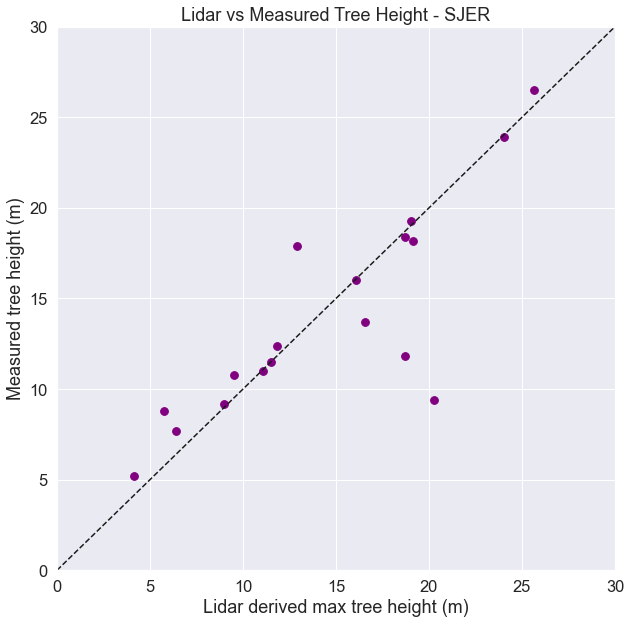

In [2]:
# Get the max and mean stem height for each plot
insitu_stem_ht = SJER_insitu.groupby("plotid", as_index=False)
insitu_stem_ht = insitu_stem_ht["stemheight"].agg(["max", "mean"])
insitu_stem_ht = insitu_stem_ht.rename(
    columns={"max": "insitu_maxht", "mean": "insitu_meanht"})
insitu_stem_ht.reset_index(inplace=True)

# First rename columns so that we know which belongs to lidar
SJER_lidar_height_df = SJER_lidar_height_df.rename(
    columns={"max": "lidar_max", "mean": "lidar_mean", "min": "lidar_min"})

# Join the data
SJER_final_height = SJER_lidar_height_df.merge(insitu_stem_ht,
                                              left_on="Plot_ID",
                                              right_on="plotid")

# Convert to a dataframe so we can use standard pandas plotting
SJER_final_height_df = pd.DataFrame(SJER_final_height)

# Plot scatter plot
fig, ax = plt.subplots(figsize=(10, 10))

# csfont = {"fontname": Myriad Pro}
SJER_final_height_df.plot("lidar_max", "insitu_maxht",
                         kind="scatter", color="purple",
                         s=60, ax=ax)

# Add a diagonal line
ax.set(xlim=[0, 30], ylim=[0, 30], label="Data")
ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls="--",
       c="k", label="1:1 line")

ax.set(xlabel="Lidar derived max tree height (m)",
      ylabel="Measured tree height (m)", title="Lidar vs Measured Tree Height - SJER")

In practice, observations from different methods rarely show a 1:1 relationship. For example above, you can see how Lidar estimates compare to human made measurements of tree height- Notice that some measurements are similar, and close to the 1:1 line. In other cases, when points lie above or below the 1:1 line, the measurements are different.

This all assumes that you decide that the human measurement is correct all of the time.

![1to1](1to1.png)

A 1:1 line is a start at comparing 2 sets of measurements. However, what if you want to predict 1 measurement from another? For example, given a measurement of lidar derived tree height, what would be the measured tree height on the ground?

Linear regression is a way to predict 1 measurement from another. It accounts for the fact that the linear relationship between the 2 variables might not be a 1 to 1 line, and that there may be variation in the data around the line.

Linear regression requires 2 variables:
1. an independent variable - let's call it x and
2. a dependent variable - let's call it y

Linear regression uses x to predict y by finding the "best fit" line between x and y, assuming the following model:

## y = a + bx + error

Where:
- a is an intercept and
- b is a slope

Conceptually "best fit" implies that the error term is minimised. One measure of fit is R-squared. When R2 is close to 1, the model fits well, and when R2 is close to 0, the model fits poorly.

You can run a regression analysis on the data above using the stats package in scipy.

In [4]:
from scipy import stats

x = SJER_final_height_df.lidar_max
y = SJER_final_height_df.insitu_maxht

slope, intercept, r_value, _, _ = stats.linregress(x, y)

print("slope:", slope,
     "\nintercept:", intercept,
     "\nr squared:", r_value**2)

slope: 0.7607314439776317 
intercept: 2.9814664744344466 
r squared: 0.6910551716430494


### Translating the output

Intercept 2.98: Here our intercept is close to 3. This means that if the Lidar derived height were 0, the estimated ground truth height would be close to 3, which may suggest some systematic offset between the Lidar and ground measurement of height. But, we should be careful with this interpretation, because we did not have any Lidar data with 0 height measurements. Any conclusions we draw about such observations are extrapolations beyond the range of data that were observed.

Slope of 0.76: The slope is positive and while it's not 1, it's also not that far from 1 at 0.76. This is not terrible. This slope suggests that for a 1 m increase in lidar derived height, we expect a 76cm increase in ground truth height. This actually could make some sense if you think about how difficult it can be to measure tall trees manually. Buzt how hard it might be for Lidar system to reflect off of shorter and potentially smaller trees

R squared of 0.69: This tells us that the linear regression model explains 69% of the variability found in the data.

Overall with results like these we can conclude that lidar does a reasonable job of estimating tree height.

## Plot regression fits compared to 1:1

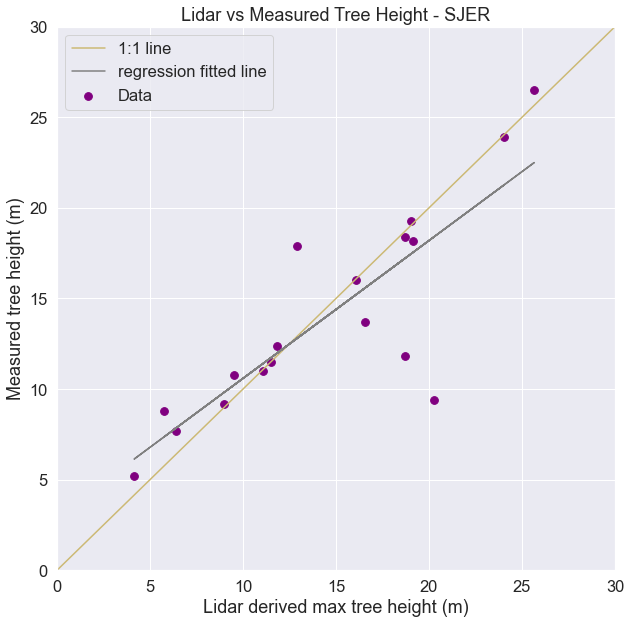

In [6]:
# Create scatter oplot
fig, ax = plt.subplots(figsize=(10, 10))

m = slope.astype(float)

SJER_final_height_df.plot("lidar_max", "insitu_maxht",
                         kind="scatter", color="purple",
                         s=60, ax=ax, label="Data")

# Add a diagonal line
ax.set(xlim=[0, 30], ylim=[0, 30])
ax.plot((0, 1), (0, 1), "y-", transform=ax.transAxes, label="1:1 line")
ax.plot(x, m*x + intercept, "grey", label="regression fitted line")

ax.set(xlabel="Lidar derived max tree height (m)",
      ylabel="Measured tree height (m)", title="Lidar vs Measured Tree Height - SJER")

plt.legend()

### Good fit, large intercept

Sometimes the question you are asking is whether 1 variable is the same (or similar to) another variable. In this case a model with a strong relationship, may still tell you that the 2 variables do not necessarily measure the same thing. For example, y model with strong R-squared value may have a large intercept. In this case you know there is a significant bias where your predictor might under or overestimate the variable of interest:

Example: Lidar has a very strong fit with human measurements but the slope is very small and the intercept is very large. See below:

slope: 1.0 
intercept: 10.0 
r squared 1.0 
p value 1.9206748078018256e-50 
st error 0.0 
RMSE 0.0


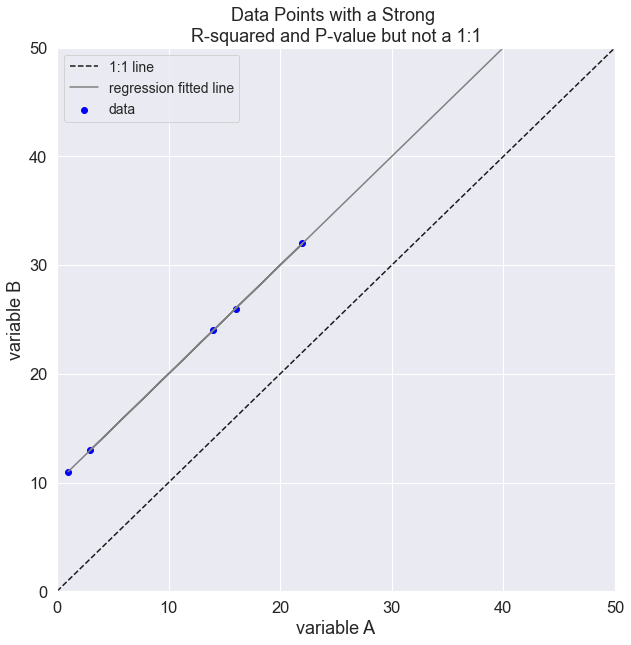

In [10]:
# Create some points with a 1 to 1 relationships
x = np.array([1, 22, 3, 14, 16, 45, 45])
y = np.array([item+10 for item in x])

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(x, y, c="blue", label="data")

ax.plot((0, 1), (0, 1), transform=ax.transAxes,
       ls="--", c="k", label="1:1 line")

ax.plot(x, intercept + slope*x, "grey", label="regression fitted line")

ax.set(xlim=[0, 50], ylim=[0, 50])

ax.set(xlabel="variable A", ylabel="variable B",
      title="Data Points with a Strong \nR-squared and P-value but not a 1:1")

plt.legend(fontsize=14)

print("slope:", slope,
     "\nintercept:", intercept,
     "\nr squared", r_value**2,
     "\np value", p_value,
     "\nst error", std_err,
     "\nRMSE", sqrt(std_err))

Similarly maybe there is a positive bias in your predictor:

slope: 1.0 
 intercept: -5.0 
 r squared: 1.0 
 p-value 1.9206748078018256e-50 
 st_error 0.0 
 RMSE 0.0


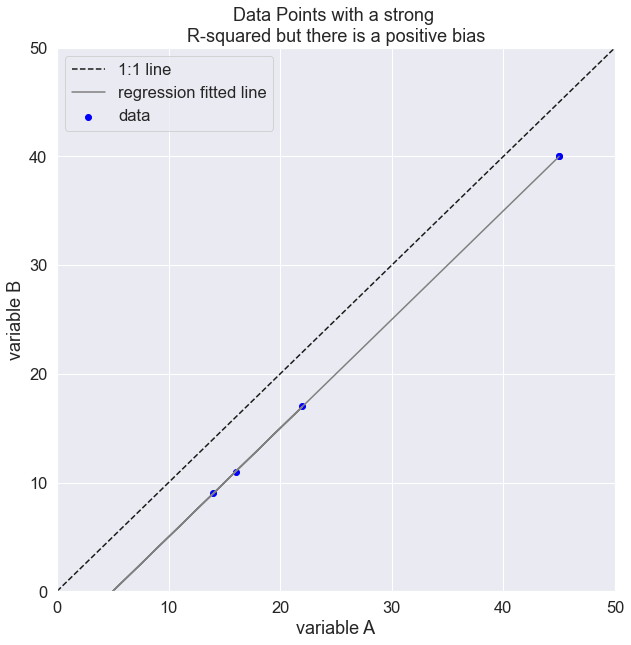

In [11]:
# Create some points wiht a 1 to 1 relationships
x = np.array([1, 22, 3, 14, 16, 45, 45])
y = np.array([item-5 for item in x])

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(x, y, c="blue", label="data")
ax.plot((0, 1), (0, 1), transform=ax.transAxes,
       ls="--", c="k", label="1:1 line")

ax.plot(x, intercept + slope*x, "grey", label="regression fitted line")

ax.set(xlim=[0, 50], ylim=[0, 50])

ax.set(xlabel="variable A", ylabel="variable B",
      title="Data Points with a strong \nR-squared but there is a positive bias")

plt.legend()

print("slope:", slope,
     "\n intercept:", intercept,
     "\n r squared:", r_value**2,
     "\n p-value", p_value,
     "\n st_error", std_err,
     "\n RMSE", sqrt(std_err))

### Other linear regression model outputs

The outputs of a linear regression model help you assess how statistically useful or significant the model is as compared to a hypothesis or theory that there is no relationship between the variables. If the data have no relationship, then the slope of the line is 0. In scientific terms this translates to whether you want to trust the model or not. These outputs includes:

RMSE: RMSE is an overall measure of how far the y-values lie from the estimated line on average. You can think of it as on average, how far away form a 1:1 relationship are the predicted data. If Lidar is predicting human measurement is it on average 1m taller, 2m shorter, etc.? Technically defined, it's defined as teh sqrt of the variance of the residuals.

P-value: The p-value can be used to see how consistent the data are with the notion that the true slope of the line is 0 (that there is no relationship between the variables of interest). A threshold of 0.05 is commonly used to determine whether there is sufficient evidence to reject the hypothesis that the true slope is 0. If p < 0.05, then one typically concludes the true slope is nonzero, though this threshold is arbitary.

Note that to calculate the RMSE you take the sqrt of the standard error.

slope: 1.0 
 intercept: -5.0 
 r squared: 1.0 
 p-value: 1.9206748078018256e-50 
 st_error 0.0 
 RMSE 0.0


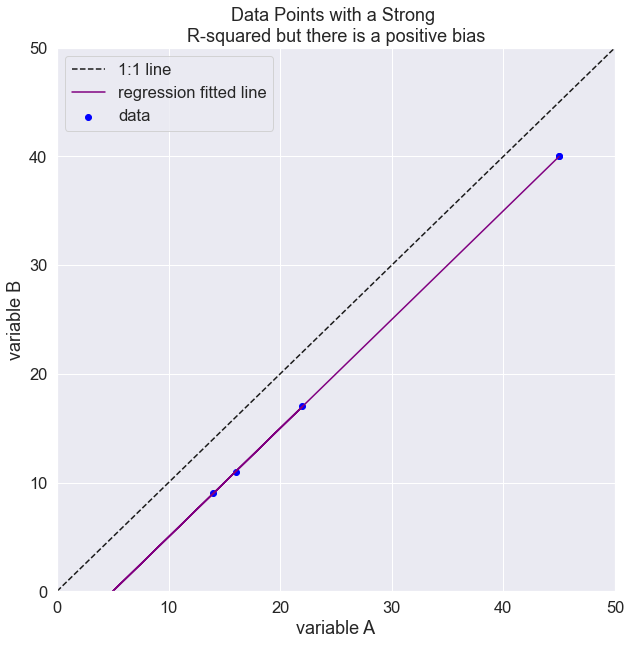

In [13]:
# Create some points with 1:1 relationships
x = np.array([1, 22, 3, 14, 16, 45, 45])
y = np.array([item-5 for item in x])

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(x, y, c="blue", label="data")

ax.plot((0, 1), (0, 1), transform=ax.transAxes,
       ls="--", c="k", label="1:1 line")

ax.plot(x, intercept + slope*x, "grey", label="regression fitted line",
       color="purple")

ax.set(xlim=[0, 50], ylim=[0, 50])

ax.set(xlabel="variable A", ylabel="variable B",
      title="Data Points with a Strong \nR-squared but there is a positive bias")

plt.legend()

print("slope:", slope,
     "\n intercept:", intercept,
     "\n r squared:", r_value**2,
     "\n p-value:", p_value,
     "\n st_error", std_err,
     "\n RMSE", sqrt(std_err))

### Use seaborn to plot regression fit

Below is a plot of the same data using the seaborn package. The seaborn package wraps around matplotlib. It makes it easier to make nice looking plots, quickly.

[Text(0, 0.5, 'Measured tree height (m)'),
 Text(0.5, 0, 'Lidar derived max tree height (m)'),
 Text(0.5, 1.0, 'Lidar vs Measured tree height - SJER')]

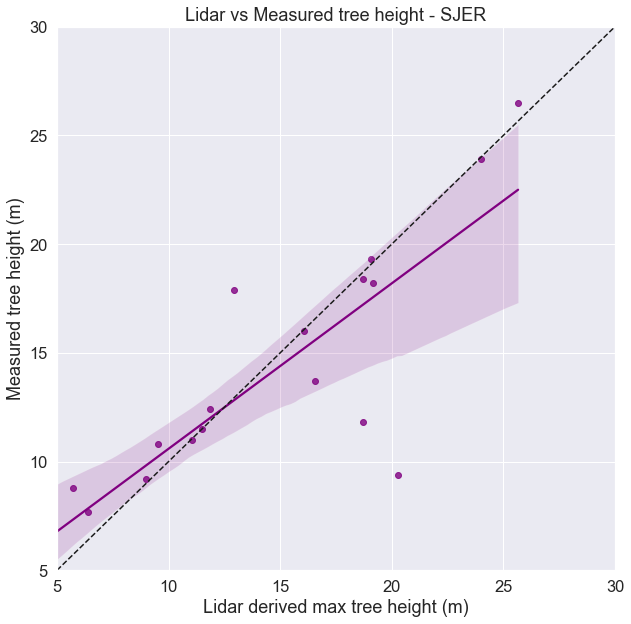

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))

ax = sns.regplot("lidar_max", "insitu_maxht", data=SJER_final_height_df,
                color="purple")

# Add a diagonal line
ax.set(xlim=[5, 30], ylim=[5, 30])
ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls="--", c="k")

ax.set(xlabel="Lidar derived max tree height (m)",
      ylabel="Measured tree height (m)", title="Lidar vs Measured tree height - SJER")

## View difference: Lidar vs Measured

A non stats approach to understand the relationship between these 2 variables is a plain old difference plot. Below you can identify which ground plots have the largest difference and which ones have the smallest. If you were workihng with these data, you might want to explore each individual plot to see if you can figure out why this relationship works better in some plots compared to others.

Below is the code for challenge opportunity in the last lesson.

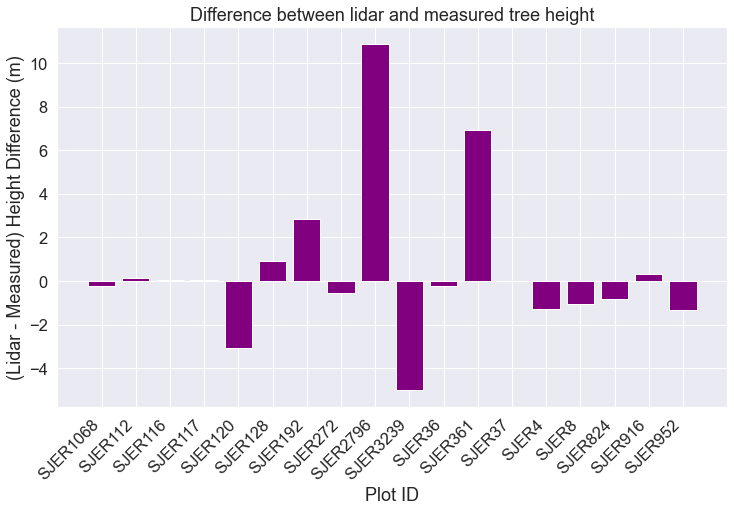

In [17]:
# Calculate difference and add the plot id to each xaxis label
SJER_final_height["lidar_measured"] = SJER_final_height["lidar_max"] - \
    SJER_final_height["insitu_maxht"]

fig, ax = plt.subplots(figsize=(12, 7))

ax.bar(SJER_final_height["plotid"], SJER_final_height["lidar_measured"],
      color="purple")

ax.set(xlabel="Plot ID", ylabel="(Lidar - Measured) Height Difference (m)",
      title="Difference between lidar and measured tree height")

plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment="right")

plt.show()